In [68]:
import pandas as pd
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from google.colab import drive

In [2]:
titanic_train = pd.read_csv("train.csv")
titanic_test = pd.read_csv("test.csv")

## 2. Exploratory Data Analysis

In [3]:
# Checking for missing values
missing_values = titanic_train.isna().sum()
missing_values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
print(titanic_train.shape)
print(titanic_test.shape)

(891, 12)
(418, 11)


## 3. Data preprocessing and Feature Engineering

### 3.1 Handling missing values

Age: is numerical, and first we will simply try to replace it with the mean

In [5]:
titanic_train['Age'].fillna(titanic_train['Age'].mean(), inplace=True)
titanic_test['Age'].fillna(titanic_train['Age'].mean(), inplace=True)
titanic_test['Fare'].fillna(titanic_test['Fare'].mean(), inplace=True)

Cabin: With the cabin it is a little bit more complicated, we can attempt to find a correlation with the passenger class. Intuitively, the cabin numbers should rely on the passenger class to some degree. So taking a very shallow approach we can try to evaluate model performance with just dropping the column.

In [6]:
titanic_train.drop('Cabin', axis=1, inplace=True)
titanic_test.drop('Cabin', axis=1, inplace=True)

Embarked: We will replace the two missing values with the most frequent value, the mode.

In [7]:
titanic_train['Embarked'].fillna(titanic_train['Embarked'].mode().iloc[0], inplace=True)

### 3.2 Handle categorical values

In [8]:
categorical_columns = [col for col in titanic_train.columns if titanic_train[col].dtype == "object"]
categorical_columns

['Name', 'Sex', 'Ticket', 'Embarked']

We can now check the number of unique occurences for each feature ['Name', 'Sex', 'Ticket', 'Embarked'] and see which encoding makes sense. 

In [9]:
for col in categorical_columns:
  print(col, titanic_train[col].nunique())

Name 891
Sex 2
Ticket 681
Embarked 3


Embarked: We can one hot encode embarked

Sex: We can one hot encode sex

Ticket: We could either Label Encode the Ticket, adding no additional values with otherwise adding 891*681 values to one-hot encoding, or drop it, since it has over 75% of missing rate giving almost everyone (but small children probably) individual tickets and the learning possibilities very low.

Name: We choose to drop the name

In [10]:
titanic_train.drop('Name', axis=1, inplace=True)
titanic_test.drop('Name', axis=1, inplace=True)

In [11]:
titanic_train = pd.get_dummies(titanic_train, columns=['Embarked', 'Sex'])
titanic_test = pd.get_dummies(titanic_test, columns=['Embarked', 'Sex'])

In [12]:
titanic_train.drop('Ticket', axis=1, inplace=True)
titanic_test.drop('Ticket', axis=1, inplace=True)

In [13]:
# thisis what we are left with
titanic_train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
Sex_female     0
Sex_male       0
dtype: int64

In [14]:
titanic_test.isna().sum()

PassengerId    0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
Sex_female     0
Sex_male       0
dtype: int64

In [15]:
X_train = titanic_train.drop('Survived', axis=1)
X_test = titanic_test
y_train = titanic_train['Survived']

In [16]:
X_train.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,1,3,22.0,1,0,7.2500,0,0,1,0,1
1,2,1,38.0,1,0,71.2833,1,0,0,1,0
2,3,3,26.0,0,0,7.9250,0,0,1,1,0
3,4,1,35.0,1,0,53.1000,0,0,1,1,0
4,5,3,35.0,0,0,8.0500,0,0,1,0,1


In [17]:
X_test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,892,3,34.5,0,0,7.8292,0,1,0,0,1
1,893,3,47.0,1,0,7.0000,0,0,1,1,0
2,894,2,62.0,0,0,9.6875,0,1,0,0,1
3,895,3,27.0,0,0,8.6625,0,0,1,0,1
4,896,3,22.0,1,1,12.2875,0,0,1,1,0


In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
def make_submission(y_pred):
  table = {'PassengerId': titanic_test.PassengerId, 'Survived': y_pred}
  submission = pd.DataFrame(data=table)

  drive.mount("drive", force_remount=True)
  submission.to_csv("submission.csv", index=False)
  !cp submission.csv "drive/My Drive/"

  return submission

# 4 Training the model

We are faced with a binary classification problem and will therefore try the following:

Performance and Simplicity:
1. Multivariate Logistic Regression
2. Decision Tree
3. k-Nearest-Neighbors
4. Linear SVM (although we do not have a lot of features)


Accuracy:
1. Deep Neural Network with sigmoid in single output node
2. Random Forest

### 4.1 Multivariate Logistic Regression

In [ ]:
lrmodel = LogisticRegression()
lrmodel.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred_log = lrmodel.predict(X_test)

In [ ]:
logistic_submission = make_submission(y_pred_log)

Mounted at drive


In [ ]:
logistic_submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


Using this simple feature engineering, we observe an accuracy of 0.76315 according to Kaggle.

### 4.2 Decision Tree

In [64]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

y_pred_tree = clf.predict(X_test)

In [65]:
tree_submission = make_submission(y_pred_tree)

Mounted at drive


In [66]:
tree_submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


Using the decison tree we can observe an accuracy of 0.77990.

### 4.3 k-Nearest-Neighbor

In [32]:
neigh = KNeighborsClassifier(n_neighbors=13)
neigh.fit(X_train, y_train)

y_pred_neigh = neigh.predict(X_test)

In [33]:
neigh_submission = make_submission(y_pred_neigh)

Mounted at drive


In [34]:
neigh_submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


KNN with 10 neighbors scores 0.78229   
while   
KNN with 3 neighbors scores 0.77511  
while    
KNN with 7 neighbors scores 0.76794    
while  
KNN with 13 neighbors scores 0.77033

### 4.4 Linear SVM

In [37]:
clfs = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clfs.fit(X_train, y_train)

y_pred_svm = clfs.predict(X_test)

In [38]:
svm_submission = make_submission(y_pred_svm)

Mounted at drive


In [39]:
svm_submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


According to Kaggle the SVC scored an Accuracy of 0.78468

### 4.5 DNN

In [40]:
X_train.shape

(891, 11)

In [54]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=[11]),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

Epoch 1/350
14/14 [==============================] - 2s 5ms/step - loss: 0.1717 - mae: 0.1717
Epoch 2/350
14/14 [==============================] - 0s 6ms/step - loss: 0.1710 - mae: 0.1710
Epoch 3/350
14/14 [==============================] - 0s 5ms/step - loss: 0.1712 - mae: 0.1712
Epoch 4/350
14/14 [==============================] - 0s 5ms/step - loss: 0.1765 - mae: 0.1765
Epoch 5/350
14/14 [==============================] - 0s 5ms/step - loss: 0.1772 - mae: 0.1772
Epoch 6/350
14/14 [==============================] - 0s 5ms/step - loss: 0.1751 - mae: 0.1751
Epoch 7/350
14/14 [==============================] - 0s 6ms/step - loss: 0.1742 - mae: 0.1742
Epoch 8/350
14/14 [==============================] - 0s 6ms/step - loss: 0.1820 - mae: 0.1820
Epoch 9/350
14/14 [==============================] - 0s 5ms/step - loss: 0.1733 - mae: 0.1733
Epoch 10/350
14/14 [==============================] - 0s 5ms/step - loss: 0.1734 - mae: 0.1734
Epoch 11/350
14/14 [==============================] - 0s 6m

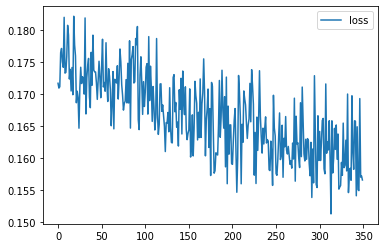

In [56]:
model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=['mae'],
)
EPOCHS = 350
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=EPOCHS,
    verbose=1,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss']].plot()

In [58]:
y_pred_dnn = model.predict(X_test)

y_pred_nn = list()

for val in y_pred_dnn:
  if val >= .5:
    y_pred_nn.append(1)
  else:
    y_pred_nn.append(0)

In [59]:
dnn_submission = make_submission(y_pred_nn)

Mounted at drive


In [60]:
dnn_submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


This particular dnn reports a score of: 0.76794

### 4.6 Random Forest

In [65]:
clff = RandomForestClassifier(n_estimators=100, random_state=0)
clff.fit(X_train, y_train)

y_pred_forest = clff.predict(X_test)

In [66]:
clff_submission = make_submission(y_pred_forest)

Mounted at drive


In [67]:
clff_submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


The random forest, consisting of 100 trees, reports a score of 